# Dropout and maxout
In this lab we will explore the methods of [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf), a regularisation method which stochastically drops out activations from the model during training, and [maxout](http://www.jmlr.org/proceedings/papers/v28/goodfellow13.pdf), another non-linear transformation that can be used in multiple layer models. This is based on material covered in the [fifth lecture slides](http://www.inf.ed.ac.uk/teaching/courses/mlp/2016/mlp05-hid.pdf).

In [1]:
import sys
mlpracticalDir = '/home/student/Dropbox/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical'
sys.path.append(mlpracticalDir)

In [2]:
import numpy as np

## Exercise 1: Implementing a dropout layer

During training the forward propagation through a dropout layer produces outputs where a subset of the input dimensions are set to zero ('dropped out'). The dimensions to be dropped out are randomly sampled for each new batch, with each dimension having a probability $p$ of being included and the inclusion (or not) of each dimension independent of all the others. If the inputs to a dropout layer are $D$ dimensional vectors then we can represent the dropout operation by an elementwise multiplication by a $D$ dimensional *binary mask* vector $\boldsymbol{m} = \left[m_1 ~ m_2 ~\dots~ m_D\right]^{\rm T}$ where $m_d \sim \text{Bernoulli}(p) ~~\forall d \in \lbrace 1 \dots D\rbrace$. 

As a first step implement a `random_binary_mask` function in the cell below to generate a binary mask array of a specified shape, where each value in the outputted array is either a one with probablity `prob_1` or zero with probability `1 - prob_1` and all values are sampled independently.

In [3]:
rng = np.random#.RandomState(seed=0)

prob_1 = 0.8

rng.binomial(1, prob_1, (3,3))

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

In [4]:
def random_binary_mask(prob_1, shape, rng):
    """Generates a random binary mask array of a given shape.
    
    Each value in the outputted array should be an indepedently sampled
    binary value i.e in {0, 1} with the probability of each value
    being 1 being equal to `prob_1`.
    
    Args:
        prob_1: Scalar value in [0, 1] specifying probability each
            entry in output array is equal to one.
        shape: Shape of returned mask array.
        rng (RandomState): Seeded random number generator object.
    
    Returns:
        Random binary mask array of specified shape.
    """
    #raise NotImplementedError()
    return rng.binomial(1, prob_1, shape)

Test your `random_binary_mask` function using the cell below (if your implementation is incorrect you will get an `AssertionError` - look at what the assert statement is checking for a clue as to what is wrong).

In [5]:
import numpy as np
test_shapes = [(1, 1000), (10, 10, 10)]
test_probs = [0.1, 0.5, 0.7]
for i in range(10):
    for shape in test_shapes:
        for prob in test_probs:
            output = random_binary_mask(prob, shape, np.random)
            # Check generating correct shape output
            assert output.shape == shape
            # Check all outputs are binary values
            assert np.all((output == 1.) | (output == 0.))
            # Check proportion equal to one plausible
            # This will be noisy so there is a chance this will error
            # even for a correct implementation
            assert np.abs(output.mean() - prob) < 0.1

Given a randomly sampled binary mask $\boldsymbol{m}$, the outputs $\lbrace \boldsymbol{y}^{(b)} \rbrace_{b=1}^B$ of the stochastic forward propagation through a dropout layer given a batch of inputs $\lbrace \boldsymbol{x}^{(b)} \rbrace_{b=1}^B$ can be calculated by simply performing an elementwise multiplication of the inputs with the mask

\begin{equation}
  y^{(b)}_d = m_k x^{(b)}_d \qquad \forall d \in \lbrace 1 \dots D \rbrace
\end{equation}

The corresponding partial derivatives required for implementing back-propagation through a dropout layer are

\begin{equation}
  \frac{\partial y^{(b)}_k}{\partial x^{(b)}_d} = 
  \begin{cases}
      m_k & \quad k = d \\
      0   & \quad k \neq d
  \end{cases}
  \qquad \forall k,\,d \in \lbrace 1 \dots D \rbrace
\end{equation}

As discussed in the lecture slides, when using a model trained with dropout at test time dimensions are no longer stochastically dropped out and instead all activations are deterministically fed forward through the model. So that the expected (mean) outputs of each layer are the same at test and training we scale the forward propagated inputs during testing by $p$ the probability of each dimension being included in the output. If we denote the deterministically forward-propagated batch of outputs of a dropout layer at test time as $\lbrace \boldsymbol{z}^{(b)} \rbrace_{b=1}^B$ then we have

\begin{equation}
  z^{(b)}_d =
  \mathbb{E}\left[ y^{(b)}_d \right] = 
  \sum_{m_d \in \lbrace 0,1 \rbrace} \left( \mathbb{P}\left[\mathrm{m}_d = m_d\right] m_d x^{(b)}_d \right) =
  (p) (1) x^{(b)}_d  + (1-p) (0) x^{(b)}_d =
  p x^{(b)}_d  \qquad \forall d \in \lbrace 1 \dots D \rbrace
\end{equation}

To allow switching between this stochastic training time behaviour and deterministic test time behaviour, a new abstract `StochasticLayer` class has been defined in the `mlp.layers` module. This acts similarly to the layer objects we have already encountered other than adding an extra boolean argument `stochastic` to the `fprop` method interface. When `stochastic = True` (the default) a stochastic forward propagation should be caculated, for dropout this corresponding to $\boldsymbol{x}^{(b)} \to \boldsymbol{y}^{(b)}$ above. When `stochastic = False` a deterministic forward-propagation corresponding to the expected output of the stochastic forward-propagation should be calculated, for dropout this corresponding to $\boldsymbol{x}^{(b)} \to \boldsymbol{z}^{(b)}$ above.

Using the skeleton `DropoutLayer` class definition below, implement the `fprop` and `bprop` methods. You may wish to store the binary mask used in the forward propagation as an attribute of the class for use in back-propagation - it is fine to assume that the `fprop` and `bprop` will always be called in sync.

In [6]:
from mlp.layers import DropoutLayer
# from mlp.layers import StochasticLayer

# class DropoutLayer(StochasticLayer):
#     """Layer which stochastically drops input dimensions in its output."""
    
#     def __init__(self, rng=None, incl_prob=0.5):
#         """Construct a new dropout layer.
        
#         Args:
#             rng (RandomState): Seeded random number generator.
#             incl_prob: Scalar value in (0, 1] specifying the probability of
#                 each input dimension being included in the output.
#         """
#         super(DropoutLayer, self).__init__(rng)
        
#         assert incl_prob > 0. and incl_prob <= 1.
        
#         self.incl_prob = incl_prob
        
#         self.rng = np.random if rng is None else rng
        
#     def fprop(self, inputs, stochastic=True):
#         """Forward propagates activations through the layer transformation.

#         Args:
#             inputs: Array of layer inputs of shape (batch_size, input_dim).
#             stochastic: Flag allowing different deterministic
#                 forward-propagation mode in addition to default stochastic
#                 forward-propagation e.g. for use at test time. If False
#                 a deterministic forward-propagation transformation
#                 corresponding to the expected output of the stochastic
#                 forward-propagation is applied.

#         Returns:
#             outputs: Array of layer outputs of shape (batch_size, output_dim).
#         """
#         #raise NotImplementedError()
        
#         #return inputs
#         #print random_binary_mask(self.incl_prob, inputs.shape, self.rng)
#         #print inputs.shape
#         #return self.incl_prob * random_binary_mask(self.incl_prob, inputs.shape, self.rng) * inputs
        
# #         if stochastic:
# #             self.binaryMask = random_binary_mask(self.incl_prob, inputs.shape, self.rng)
# #             return self.binaryMask * inputs
# #         else:
# #             return self.incl_prob * inputs

#         self.binaryMask = random_binary_mask(self.incl_prob, inputs.shape, self.rng) if\
#             stochastic else np.ones(inputs.shape)

#         outputs = self.binaryMask * inputs
        
#         if stochastic:
#             return outputs
#         else:
#             return self.incl_prob * outputs
    
#     def bprop(self, inputs, outputs, grads_wrt_outputs):
#         """Back propagates gradients through a layer.

#         Given gradients with respect to the outputs of the layer calculates the
#         gradients with respect to the layer inputs. This should correspond to
#         default stochastic forward-propagation.

#         Args:
#             inputs: Array of layer inputs of shape (batch_size, input_dim).
#             outputs: Array of layer outputs calculated in forward pass of
#                 shape (batch_size, output_dim).
#             grads_wrt_outputs: Array of gradients with respect to the layer
#                 outputs of shape (batch_size, output_dim).

#         Returns:
#             Array of gradients with respect to the layer inputs of shape
#             (batch_size, input_dim).
#         """
#         #raise NotImplementedError()
#         #print .shape
#         return self.binaryMask * grads_wrt_outputs

#     def __repr__(self):
#         return 'DropoutLayer(incl_prob={0:.1f})'.format(self.incl_prob)

Test your implementation by running the cell below (if your implementation is incorrect you will get an `AssertionError` - look at what the assert statement is checking for a clue as to what is wrong).

In [7]:
seed = 31102016 
rng = np.random.RandomState(seed)
test_incl_probs = [0.1, 0.5, 0.7]
input_shape = (5, 10)
for incl_prob in test_incl_probs:
    layer = DropoutLayer(rng, incl_prob)
    inputs = rng.normal(size=input_shape)
    grads_wrt_outputs = rng.normal(size=input_shape)
    for t in range(100):
        outputs = layer.fprop(inputs, stochastic=True)
        # Check outputted array correct shape
        assert outputs.shape == inputs.shape
        # Check all outputs are either equal to inputs or zero
        assert np.all((outputs == inputs) | (outputs == 0))
        grads_wrt_inputs = layer.bprop(inputs, outputs, grads_wrt_outputs)
        # Check back-propagated gradients only non-zero for non-zero outputs
        assert np.all((outputs != 0) == (grads_wrt_inputs != 0))
        assert np.all(grads_wrt_outputs[outputs != 0] == grads_wrt_inputs[outputs != 0])
    det_outputs = layer.fprop(inputs, stochastic=False)
    # Check deterministic fprop outputs are correct shape
    assert det_outputs.shape == inputs.shape
    # Check deterministic fprop outputs scaled correctly
    assert np.allclose(det_outputs, incl_prob * inputs)

### Optional extension

Above we assumed the same dropout mask was applied to each input in a batch, as specified in the lecture slides. In practice sometimes a different mask is sampled for each input. As an extension you could try implementing this per-input form of dropout either by defining a new layer or adding an extra argument to the constructor of the above layer which allows you to switch between the two forms.

## Exercise 2: Training with dropout

Experiment with training models with dropout layers to classify MNIST digits. Code has been provided below as a starting point for setting up the model objects though feel free to use any additional adaptive learning rules or learning rule schedulers you wrote during the coursework instead. You may also wish to change the model architecture to use a larger model with more parameters in which the regularisation provided by dropout is likely to have a more pronounced effect. You will probably also find that models with dropout generally need to be trained over more epochs than those without (can you suggest why this might be?).

You should training with a few different `incl_prob` settings for the dropout layers and try to establish how the values chosen affect the training performance. You may wish to experiment with using a different dropout probability at the input than for the intermediate layers (why?).

You may wish to start reading through and implementing exercise 3 while waiting for training runs to complete.

#### my answer

Well since dropout erases some of the nodes of the neural network then you would expect to train the network gradually.  
In addition since the dropout can be imagined as a combination of an exponential number of networks then you would imagine that all this training of all these networks requires more time.

Yes indeed the probability of the input must be higher than the probability of the intermediate layers because we must give the chance to the neural network to see all possible variations of our inputs.  
If we use a low probability for the input is like turning off many of the pixels of our input images and we will not give "the whole picture" to our neural network. It might miss some important features.

In [8]:
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider
from mlp.models import MultipleLayerModel
from mlp.layers import ReluLayer, AffineLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.optimisers import Optimiser
import matplotlib.pyplot as plt
%matplotlib inline

# Seed a random number generator
seed = 31102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

## Simple testing (not experimenting) with Annealed Dropout Implementation

In [9]:
from mlp.schedulers import AnnealedDropoutScheduler

In [10]:
print "aa: " + ", ".join(["ee", "tt"])

aa: ee, tt


In [12]:
# Probability of input being included in output in dropout layer
startInputInclProb = 0.8
startHiddenInclProb = 0.4
num_epochs = 100

input_dim, output_dim, hidden_dim = 784, 10, 125

# Use Glorot initialisation scheme for weights and zero biases
weights_init = GlorotUniformInit(rng=rng, gain=2.**0.5)
biases_init = ConstantInit(0.)

# Create three affine layer model with rectified linear non-linearities
# and dropout layers before every affine layer
model = MultipleLayerModel([
    DropoutLayer(rng, startInputInclProb),
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
        
    DropoutLayer(rng, startHiddenInclProb),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
        
    DropoutLayer(rng, startHiddenInclProb),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError()

# Use a momentum learning rule - you could use an adaptive learning rule
# implemented for the coursework here instead
learning_rule = MomentumLearningRule(0.02, 0.9)

# Monitor classification accuracy during training
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors,
                      schedulers=[
        AnnealedDropoutScheduler(model = model,
                         startInputInclProb=startInputInclProb,
                         startHiddenInclProb=startHiddenInclProb,
                         epochs = num_epochs,
                         holdOnPercent=0.2)
    ])

stats_interval = 5

stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')

Epoch 0:
  error(train)=2.35e+00, acc(train)=1.03e-01, error(valid)=2.35e+00, acc(valid)=9.99e-02, params_penalty=0.00e+00
input incl prob: 0.800000
hidden incl prob: 0.400000
all probs from model: 0.8, 0.4, 0.4
input incl prob: 0.802532
hidden incl prob: 0.407595
all probs from model: 0.80253164557, 0.407594936709, 0.407594936709
input incl prob: 0.805063
hidden incl prob: 0.415190
all probs from model: 0.805063291139, 0.415189873418, 0.415189873418
input incl prob: 0.807595
hidden incl prob: 0.422785
all probs from model: 0.807594936709, 0.422784810127, 0.422784810127
input incl prob: 0.810127
hidden incl prob: 0.430380
all probs from model: 0.810126582278, 0.430379746835, 0.430379746835


KeyboardInterrupt: 

## Lab starts here

Epoch 0:
  error(train)=2.33e+00, acc(train)=9.90e-02, error(valid)=2.32e+00, acc(valid)=9.43e-02, params_penalty=0.00e+00
Epoch 5: 7.34s to complete
  error(train)=4.33e-01, acc(train)=8.70e-01, error(valid)=4.04e-01, acc(valid)=8.79e-01, params_penalty=0.00e+00
Epoch 10: 6.02s to complete
  error(train)=3.54e-01, acc(train)=8.92e-01, error(valid)=3.39e-01, acc(valid)=9.02e-01, params_penalty=0.00e+00
Epoch 15: 7.42s to complete
  error(train)=3.24e-01, acc(train)=9.03e-01, error(valid)=3.23e-01, acc(valid)=9.03e-01, params_penalty=0.00e+00
Epoch 20: 6.99s to complete
  error(train)=3.00e-01, acc(train)=9.09e-01, error(valid)=2.89e-01, acc(valid)=9.16e-01, params_penalty=0.00e+00
Epoch 25: 9.78s to complete
  error(train)=2.92e-01, acc(train)=9.11e-01, error(valid)=2.77e-01, acc(valid)=9.16e-01, params_penalty=0.00e+00
Epoch 30: 6.63s to complete
  error(train)=2.79e-01, acc(train)=9.16e-01, error(valid)=2.60e-01, acc(valid)=9.21e-01, params_penalty=0.00e+00
Epoch 35: 6.28s to complet

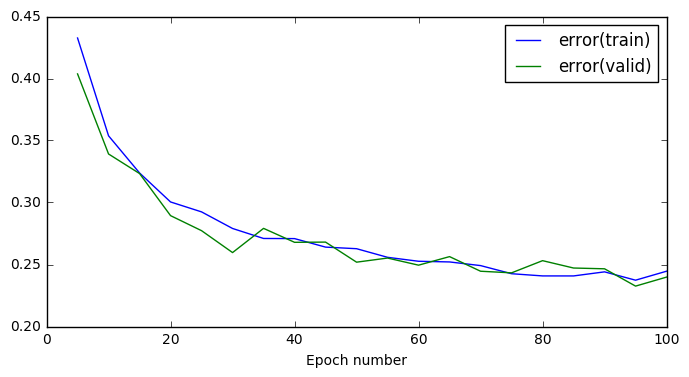

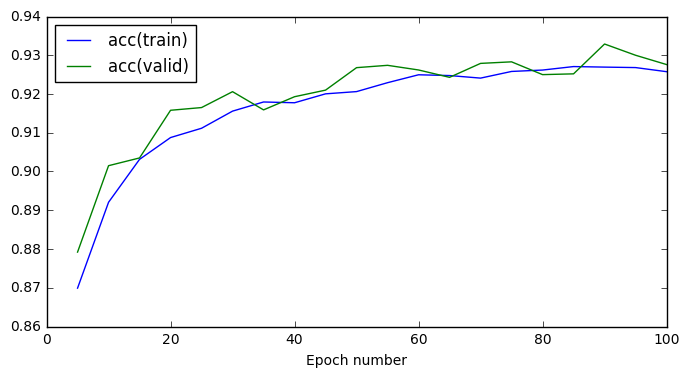

In [95]:
# Probability of input being included in output in dropout layer
incl_prob = 0.5

input_dim, output_dim, hidden_dim = 784, 10, 125

# Use Glorot initialisation scheme for weights and zero biases
weights_init = GlorotUniformInit(rng=rng, gain=2.**0.5)
biases_init = ConstantInit(0.)

# Create three affine layer model with rectified linear non-linearities
# and dropout layers before every affine layer
model = MultipleLayerModel([
    DropoutLayer(rng, incl_prob),
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError()

# Use a momentum learning rule - you could use an adaptive learning rule
# implemented for the coursework here instead
learning_rule = MomentumLearningRule(0.02, 0.9)

# Monitor classification accuracy during training
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

optimiser = Optimiser(
    model, error, learning_rule, train_data, valid_data, data_monitors)

num_epochs = 100
stats_interval = 5

stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')

Yes indeed after 100 epochs it has not reached at a high place, so it seems that dropout needs more time

Epoch 0:
  error(train)=2.30e+00, acc(train)=1.01e-01, error(valid)=2.30e+00, acc(valid)=9.87e-02, params_penalty=0.00e+00
Epoch 5: 3.07s to complete
  error(train)=2.13e+00, acc(train)=2.27e-01, error(valid)=2.12e+00, acc(valid)=2.23e-01, params_penalty=0.00e+00
Epoch 10: 2.90s to complete
  error(train)=1.73e+00, acc(train)=3.76e-01, error(valid)=1.72e+00, acc(valid)=3.79e-01, params_penalty=0.00e+00
Epoch 15: 2.97s to complete
  error(train)=1.60e+00, acc(train)=4.35e-01, error(valid)=1.56e+00, acc(valid)=4.46e-01, params_penalty=0.00e+00
Epoch 20: 3.02s to complete
  error(train)=1.52e+00, acc(train)=4.65e-01, error(valid)=1.49e+00, acc(valid)=4.74e-01, params_penalty=0.00e+00
Epoch 25: 3.15s to complete
  error(train)=1.49e+00, acc(train)=4.86e-01, error(valid)=1.44e+00, acc(valid)=5.01e-01, params_penalty=0.00e+00
Epoch 30: 3.27s to complete
  error(train)=1.45e+00, acc(train)=5.03e-01, error(valid)=1.41e+00, acc(valid)=5.14e-01, params_penalty=0.00e+00
Epoch 35: 3.18s to complet

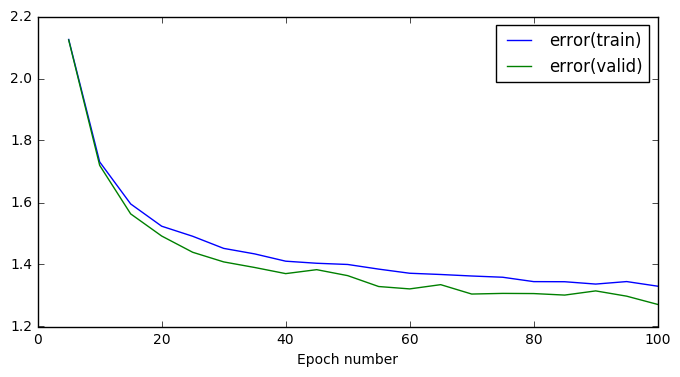

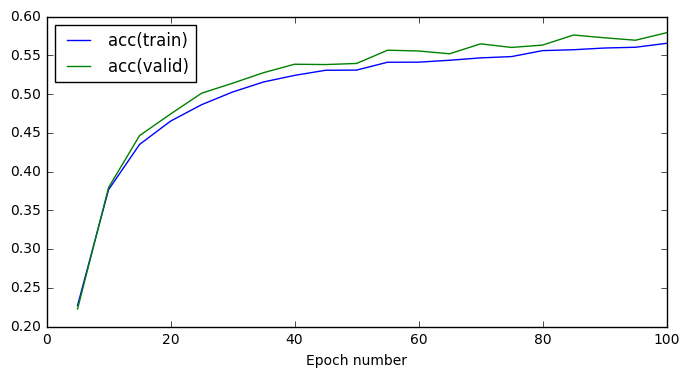

In [98]:
# Probability of input being included in output in dropout layer
incl_prob = 0.15
num_epochs = 100

input_dim, output_dim, hidden_dim = 784, 10, 125

# Use Glorot initialisation scheme for weights and zero biases
weights_init = GlorotUniformInit(rng=rng, gain=2.**0.5)
biases_init = ConstantInit(0.)

# Create three affine layer model with rectified linear non-linearities
# and dropout layers before every affine layer
model = MultipleLayerModel([
    DropoutLayer(rng, incl_prob),
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError()

# Use a momentum learning rule - you could use an adaptive learning rule
# implemented for the coursework here instead
learning_rule = MomentumLearningRule(0.02, 0.9)

# Monitor classification accuracy during training
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

optimiser = Optimiser(
    model, error, learning_rule, train_data, valid_data, data_monitors)

stats_interval = 5

stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')

It seems that with very low probability we have underfitted

Epoch 0:
  error(train)=2.43e+00, acc(train)=1.07e-01, error(valid)=2.44e+00, acc(valid)=1.04e-01, params_penalty=0.00e+00
Epoch 5: 3.68s to complete
  error(train)=1.11e-01, acc(train)=9.65e-01, error(valid)=1.33e-01, acc(valid)=9.61e-01, params_penalty=0.00e+00
Epoch 10: 3.99s to complete
  error(train)=8.58e-02, acc(train)=9.72e-01, error(valid)=1.20e-01, acc(valid)=9.63e-01, params_penalty=0.00e+00
Epoch 15: 3.01s to complete
  error(train)=6.16e-02, acc(train)=9.80e-01, error(valid)=1.07e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 20: 3.29s to complete
  error(train)=5.84e-02, acc(train)=9.81e-01, error(valid)=1.12e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 25: 3.14s to complete
  error(train)=5.13e-02, acc(train)=9.83e-01, error(valid)=1.06e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 30: 3.62s to complete
  error(train)=5.00e-02, acc(train)=9.84e-01, error(valid)=1.12e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 35: 4.26s to complet

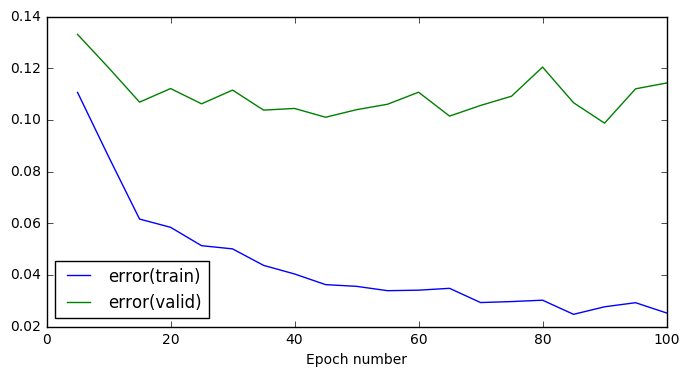

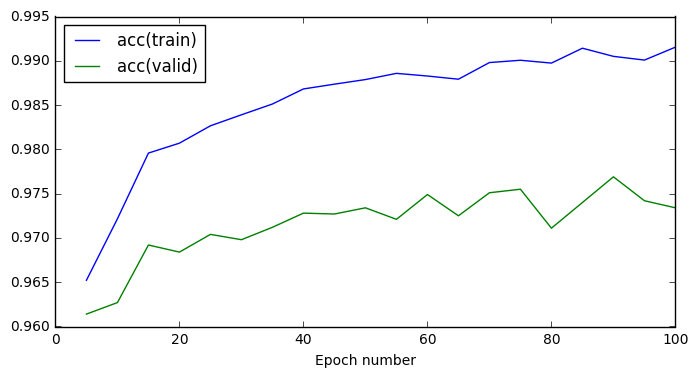

In [99]:
# Probability of input being included in output in dropout layer
incl_prob = 0.85
num_epochs = 100

input_dim, output_dim, hidden_dim = 784, 10, 125

# Use Glorot initialisation scheme for weights and zero biases
weights_init = GlorotUniformInit(rng=rng, gain=2.**0.5)
biases_init = ConstantInit(0.)

# Create three affine layer model with rectified linear non-linearities
# and dropout layers before every affine layer
model = MultipleLayerModel([
    DropoutLayer(rng, incl_prob),
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError()

# Use a momentum learning rule - you could use an adaptive learning rule
# implemented for the coursework here instead
learning_rule = MomentumLearningRule(0.02, 0.9)

# Monitor classification accuracy during training
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

optimiser = Optimiser(
    model, error, learning_rule, train_data, valid_data, data_monitors)

stats_interval = 5

stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')

We have managed to achieve better regularization meaning steady error which is not increasing as the epochs go by. We have also managed to achieve better final accuracy at 97%

Epoch 0:
  error(train)=2.35e+00, acc(train)=1.02e-01, error(valid)=2.35e+00, acc(valid)=9.81e-02, params_penalty=0.00e+00
Epoch 5: 6.31s to complete
  error(train)=4.14e-01, acc(train)=8.74e-01, error(valid)=4.01e-01, acc(valid)=8.78e-01, params_penalty=0.00e+00
Epoch 10: 6.14s to complete
  error(train)=3.49e-01, acc(train)=8.95e-01, error(valid)=3.28e-01, acc(valid)=9.05e-01, params_penalty=0.00e+00
Epoch 15: 6.53s to complete
  error(train)=3.14e-01, acc(train)=9.06e-01, error(valid)=2.79e-01, acc(valid)=9.15e-01, params_penalty=0.00e+00
Epoch 20: 5.95s to complete
  error(train)=2.96e-01, acc(train)=9.10e-01, error(valid)=2.78e-01, acc(valid)=9.17e-01, params_penalty=0.00e+00
Epoch 25: 6.02s to complete
  error(train)=2.93e-01, acc(train)=9.11e-01, error(valid)=2.68e-01, acc(valid)=9.19e-01, params_penalty=0.00e+00
Epoch 30: 6.13s to complete
  error(train)=2.73e-01, acc(train)=9.17e-01, error(valid)=2.61e-01, acc(valid)=9.22e-01, params_penalty=0.00e+00
Epoch 35: 5.87s to complet

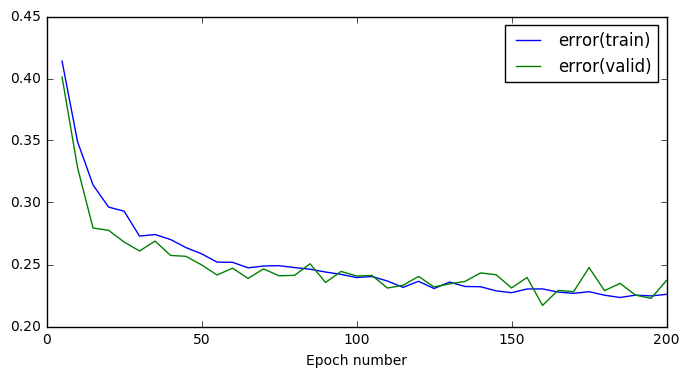

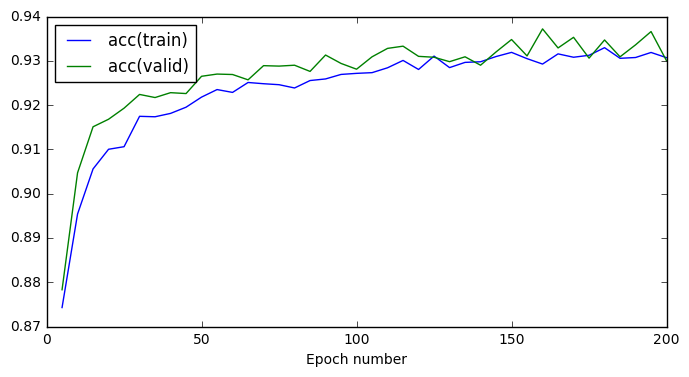

In [96]:
# Probability of input being included in output in dropout layer
incl_prob = 0.5
num_epochs = 200

input_dim, output_dim, hidden_dim = 784, 10, 125

# Use Glorot initialisation scheme for weights and zero biases
weights_init = GlorotUniformInit(rng=rng, gain=2.**0.5)
biases_init = ConstantInit(0.)

# Create three affine layer model with rectified linear non-linearities
# and dropout layers before every affine layer
model = MultipleLayerModel([
    DropoutLayer(rng, incl_prob),
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError()

# Use a momentum learning rule - you could use an adaptive learning rule
# implemented for the coursework here instead
learning_rule = MomentumLearningRule(0.02, 0.9)

# Monitor classification accuracy during training
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

optimiser = Optimiser(
    model, error, learning_rule, train_data, valid_data, data_monitors)

stats_interval = 5

stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')

Even after 200 epochs we didn't get any actual improvement in final accuracy. We could blame the learning rule here as well.

Epoch 0:
  error(train)=2.39e+00, acc(train)=1.03e-01, error(valid)=2.39e+00, acc(valid)=1.07e-01, params_penalty=0.00e+00
Epoch 5: 3.03s to complete
  error(train)=2.86e-01, acc(train)=9.15e-01, error(valid)=2.84e-01, acc(valid)=9.14e-01, params_penalty=0.00e+00
Epoch 10: 3.12s to complete
  error(train)=2.15e-01, acc(train)=9.35e-01, error(valid)=2.11e-01, acc(valid)=9.40e-01, params_penalty=0.00e+00
Epoch 15: 3.15s to complete
  error(train)=1.93e-01, acc(train)=9.42e-01, error(valid)=2.10e-01, acc(valid)=9.41e-01, params_penalty=0.00e+00
Epoch 20: 3.14s to complete
  error(train)=1.74e-01, acc(train)=9.47e-01, error(valid)=1.90e-01, acc(valid)=9.46e-01, params_penalty=0.00e+00
Epoch 25: 3.49s to complete
  error(train)=1.70e-01, acc(train)=9.49e-01, error(valid)=1.98e-01, acc(valid)=9.45e-01, params_penalty=0.00e+00
Epoch 30: 3.31s to complete
  error(train)=1.59e-01, acc(train)=9.51e-01, error(valid)=1.95e-01, acc(valid)=9.44e-01, params_penalty=0.00e+00
Epoch 35: 3.61s to complet

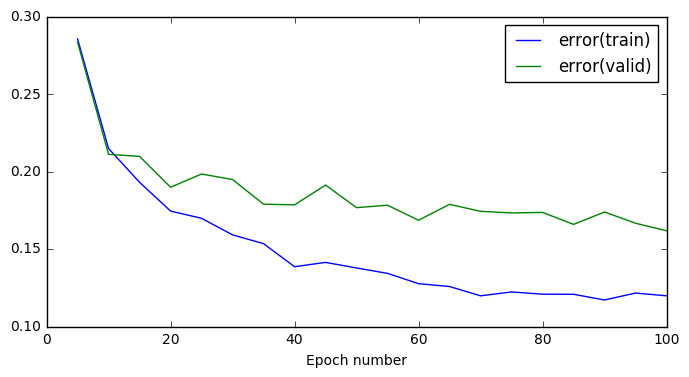

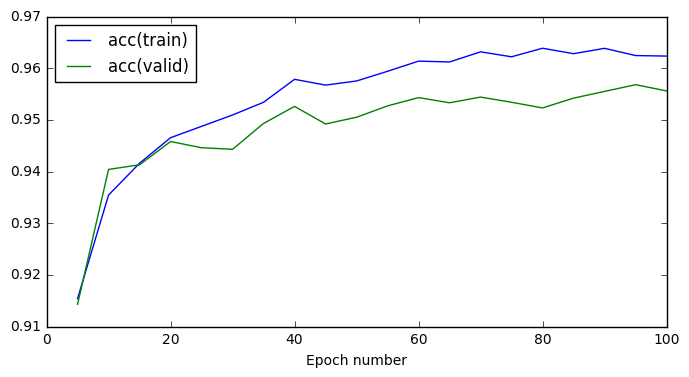

In [100]:
# Probability of input being included in output in dropout layer
initial_prob = 0.9
incl_prob = 0.5
num_epochs = 100

input_dim, output_dim, hidden_dim = 784, 10, 125

# Use Glorot initialisation scheme for weights and zero biases
weights_init = GlorotUniformInit(rng=rng, gain=2.**0.5)
biases_init = ConstantInit(0.)

# Create three affine layer model with rectified linear non-linearities
# and dropout layers before every affine layer
model = MultipleLayerModel([
    DropoutLayer(rng, initial_prob),
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError()

# Use a momentum learning rule - you could use an adaptive learning rule
# implemented for the coursework here instead
learning_rule = MomentumLearningRule(0.02, 0.9)

# Monitor classification accuracy during training
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

optimiser = Optimiser(
    model, error, learning_rule, train_data, valid_data, data_monitors)

stats_interval = 5

stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')

Still here it seems that we have not achieved better results than before since we have probably regularized too soon.

But we should note that when comparing the above with the case where the probability was 0.5 for all layers including the inputs (here we have the inputs to have 0.9 probability) we got from 93% to more than 95% final training accuracy and we have not overfitted

## Exercise 3: Implementing maxout

[Maxout](http://www.jmlr.org/proceedings/papers/v28/goodfellow13.pdf) can be considered a generalisation of the rectified linear transformation implemented in the previous lab. 

For a rectified linear (`Relu`) layer the forward propagation corresponds to

\begin{equation}
    y^{(b)}_k = 
    \max\left\lbrace 0,\,x^{(b)}_k \right\rbrace
\end{equation}

i.e. each output corresponds to an pairwise maximum of a constant (0) and the input.

Instead of taking the maximum of the input and a constant, we could instead consider taking the maximum over sets of inputs of a fixed size $s$.

\begin{equation}
    y^{(b)}_k = 
    \max\left\lbrace x^{(b)}_{(k-1)s + 1},\, x^{(b)}_{(k-1)s + 2},\, \dots ,\, x^{(b)}_{ks} \right\rbrace
\end{equation}

If these inputs $x^{(b)}_d$ are themselves the outputs of an affine layer, then this corresponds to taking the maximum of a series of affine functions of the previous layer outputs. Like a rectified linear layer this leads to piecewise linear input-output relationships (which have well-behaved gradients which do not suffer from the saturation problems of logistic sigmoid / hyperbolic tangent transformations) but unlike the rectified linear case we do not end force a portion of the outputs to be zero. 

Experimentally this form of transformation has been found to give good performance, with the name *maxout* chosen because the *out*put is the *max*imum of a set of inputs. Maxout is also commonly used with dropout layers however note they are not directly related - maxout defines a deterministic non-linear transformation which can help improve the representational capacity and trainability of models; dropout defines a stochastic transformation which is mainly aimed at regularising a model to reduce overfitting.

Using layers which take the maximum of fixed sized sets of inputs is also a common technique in models with convolutional layers which we will cover later in the course, with here the layer commonly being termed a *max-pooling* layer (with there being natural generalisation to other choices of reduction functions over pools such as the mean). We will adopt this terminology here for a layer implementing the transformation described above and we will be able to reuse our code implementing this maximum operation when experimenting with convolutional models.

The partial derivatives of this max-pooling transformation are sparse (lots of values are zero), with only the partial derivative of the output of a pool with respect to the maximum input in the pool non-zero. This can be expressed as

\begin{equation}
    \frac{\partial y^{(b)}_k}{\partial x^{(b)}_d} = 
    \begin{cases} 
      1 & \quad (k-1)s + 1 \leq d  \leq ks \quad\textrm{and} &x^{(b)}_d = \max\left\lbrace x^{(b)}_{(k-1)s + 1},\, x^{(b)}_{(k-1)s + 2},\, \dots ,\, x^{(b)}_{ks} \right\rbrace \\
      0 & \quad \textrm{otherwise}
    \end{cases}.
\end{equation}

Using these definitions implement the `fprop` and `bprop` methods of the skeleton `MaxPoolingLayer` class below.

Some hints

  * One way of organising the inputs into non-overlapping pools is using the `numpy.reshape` function.
  * The `numpy.max` function has an `axis` argument which allows you specify the axis (dimension) of the input array to take the maximum over.
  * It may help to construct a binary mask corresponding to the definitions of the partial derivatives above to allow you to implement the `bprop` method. 
  * As with the `DropoutLayer` it is fine to temporarily store values calculated in the `fprop` method as attributes of the object (e.g. `self.val = val`) to use in the `bprop` method (although you don't necessarily need to do this).

In [134]:
test_inputs = np.array([[-3, -4, 5, 8], [0, -2, 3, -8], [1, 5, 3, 2]])
shape = test_inputs.shape
#shape[-1] = 3
#shape = list(shape)
#shape[-1] = 3
#shape[:len(shape)-1] + (shape[-1]/2, 2)
#test_inputs.max(axis=-1)
newShape = shape[:len(shape)-1] + (shape[-1]/2, 2)

reshaped = np.reshape(test_inputs, newShape)
reshaped

array([[[-3, -4],
        [ 5,  8]],

       [[ 0, -2],
        [ 3, -8]],

       [[ 1,  5],
        [ 3,  2]]])

In [135]:
#maxes = reshaped.max(axis=-1)
maxes = np.amax(reshaped,axis=-1, keepdims=True)
maxes

array([[[-3],
        [ 8]],

       [[ 0],
        [ 3]],

       [[ 5],
        [ 3]]])

In [136]:
reshaped.argmax()

3

In [137]:
#np.argmax(reshaped, axis=-1)
args = reshaped.argmax(axis=-1)
args
#reshaped[0,0,1]

array([[0, 1],
       [0, 0],
       [1, 0]])

In [138]:
np.unravel_index(args, reshaped.shape)

(array([[0, 0],
        [0, 0],
        [0, 0]]), array([[0, 0],
        [0, 0],
        [0, 0]]), array([[0, 1],
        [0, 0],
        [1, 0]]))

In [139]:
np.unravel_index(np.array([3,4]), (4,2))

(array([1, 2]), array([1, 0]))

In [140]:
test = np.array([0,1])
result = np.array([[1, 0], [0, 1]])

In [141]:
#np.apply_along_axis(lambda elem: )
s = 2

In [142]:
a = np.zeros(s)
#a[0] = 1
a

array([ 0.,  0.])

In [143]:
reshaped == maxes

array([[[ True, False],
        [False,  True]],

       [[ True, False],
        [ True, False]],

       [[False,  True],
        [ True, False]]], dtype=bool)

In [144]:
(reshaped == maxes)*1

array([[[1, 0],
        [0, 1]],

       [[1, 0],
        [1, 0]],

       [[0, 1],
        [1, 0]]])

In [145]:
mask = np.array([[[0, 0, 0, 1]], [[0, 0, 1, 0]], [[0, 1, 0, 0]]])
mask

array([[[0, 0, 0, 1]],

       [[0, 0, 1, 0]],

       [[0, 1, 0, 0]]])

In [146]:
incomings = np.array([[10], [5], [-3]])
print incomings.shape
incomings

(3, 1)


array([[10],
       [ 5],
       [-3]])

In [147]:
mask.shape

(3, 1, 4)

In [148]:
shape

(3, 4)

In [149]:
incomingsNewShape = incomings.shape + (1,)
incomingsNewShape

(3, 1, 1)

In [150]:
incomingsD = np.reshape(incomings, incomingsNewShape)
incomingsD

array([[[10]],

       [[ 5]],

       [[-3]]])

In [151]:
result = mask * incomingsD
result

array([[[ 0,  0,  0, 10]],

       [[ 0,  0,  5,  0]],

       [[ 0, -3,  0,  0]]])

In [152]:
np.squeeze(result)

array([[ 0,  0,  0, 10],
       [ 0,  0,  5,  0],
       [ 0, -3,  0,  0]])

In [153]:
originallyShaped = np.reshape(mask, shape)

In [154]:
originallyShaped

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0]])

In [155]:
originallyShaped * incomings

array([[ 0,  0,  0, 10],
       [ 0,  0,  5,  0],
       [ 0, -3,  0,  0]])

In [156]:
mask * incomings[np.newaxis]

array([[[ 0,  0,  0, 10],
        [ 0,  0,  0,  5],
        [ 0,  0,  0, -3]],

       [[ 0,  0, 10,  0],
        [ 0,  0,  5,  0],
        [ 0,  0, -3,  0]],

       [[ 0, 10,  0,  0],
        [ 0,  5,  0,  0],
        [ 0, -3,  0,  0]]])

SECTION 2

In [157]:
mask = np.array([[[1, 0],  [0, 1]], [[1, 0],  [1, 0]], [[0, 1],  [1, 0]]])
mask

array([[[1, 0],
        [0, 1]],

       [[1, 0],
        [1, 0]],

       [[0, 1],
        [1, 0]]])

In [158]:
grads = np.array([[3, -1], [2, 5], [5, 3]])
print grads.shape
grads

(3, 2)


array([[ 3, -1],
       [ 2,  5],
       [ 5,  3]])

In [159]:
mask.shape

(3, 2, 2)

In [160]:
grads.shape

(3, 2)

In [162]:
grads[np.newaxis]

array([[[ 3, -1],
        [ 2,  5],
        [ 5,  3]]])

In [163]:
gradsD = np.reshape(grads, (3, 2, 1))
gradsD

array([[[ 3],
        [-1]],

       [[ 2],
        [ 5]],

       [[ 5],
        [ 3]]])

In [164]:
result = mask * gradsD
result

array([[[ 3,  0],
        [ 0, -1]],

       [[ 2,  0],
        [ 5,  0]],

       [[ 0,  5],
        [ 3,  0]]])

In [165]:
np.reshape(result, (3,4))

array([[ 3,  0,  0, -1],
       [ 2,  0,  5,  0],
       [ 0,  5,  3,  0]])

https://www.quora.com/How-are-gradients-computed-through-max-pooling-or-maxout-units-in-neural-networks

In [171]:
from mlp.layers import Layer

class MaxPoolingLayer(Layer):
    
    def __init__(self, pool_size=2):
        """Construct a new max-pooling layer.
        
        Args:
            pool_size: Positive integer specifying size of pools over
               which to take maximum value. The outputs of the layer
               feeding in to this layer must have a dimension which
               is a multiple of this pool size such that the outputs
               can be split in to pools with no dimensions left over.
        """
        assert pool_size > 0
        self.pool_size = pool_size
    
    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.
        
        This corresponds to taking the maximum over non-overlapping pools of
        inputs of a fixed size `pool_size`.

        Args:
            inputs: Array of layer inputs of shape (batch_size, input_dim).

        Returns:
            outputs: Array of layer outputs of shape (batch_size, output_dim).
        """
        assert inputs.shape[-1] % self.pool_size == 0, (
            'Last dimension of inputs must be multiple of pool size')
        #return np.maximum(0, inputs) #from relu
        shape = inputs.shape
        
        newShape = shape[:len(shape)-1] + (shape[-1]/self.pool_size, self.pool_size)
        
        pools = np.reshape(inputs, newShape)
        
        self.binaryMask = (np.amax(pools, axis=-1, keepdims=True) == pools)*1
        
        # here we want by column or by row? Are we using multiple instances or multiple attributes ?????
        # it seems like multiple attributes
        return pools.max(axis=-1)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.

        Args:
            inputs: Array of layer inputs of shape (batch_size, input_dim).
            outputs: Array of layer outputs calculated in forward pass of
                shape (batch_size, output_dim).
            grads_wrt_outputs: Array of gradients with respect to the layer
                outputs of shape (batch_size, output_dim).

        Returns:
            Array of gradients with respect to the layer inputs of shape
            (batch_size, input_dim).
        """
        #raise NotImplementedError()
        
        #print inputs.shape
        #print grads_wrt_outputs.shape
        #print self.binaryMask
        
        #maskOriginallyShaped = np.reshape(self.binaryMask, inputs.shape)
        #print maskOriginallyShaped
        
        grads_wrt_outputs_plusOneDimension = np.reshape(grads_wrt_outputs, grads_wrt_outputs.shape + (1,))
        
        grads_wrt_inputs_malformed = np.squeeze(self.binaryMask * grads_wrt_outputs_plusOneDimension)
        
        grads_wrt_inputs = np.reshape(grads_wrt_inputs_malformed, inputs.shape)

        return grads_wrt_inputs
    
        #we have a max in every column

    def __repr__(self):
        return 'MaxPoolingLayer(pool_size={0})'.format(self.pool_size)

Test your implementation by running the cell below.

In [172]:
test_inputs = np.array([[-3, -4, 5, 8], [0, -2, 3, -8], [1, 5, 3, 2]])
test_outputs_1 = np.array([[8], [3], [5]])
test_grads_wrt_outputs_1 = np.array([[10], [5], [-3]])
test_grads_wrt_inputs_1 = np.array([[0, 0, 0, 10], [0, 0, 5, 0], [0, -3, 0, 0]])
test_outputs_2 = np.array([[-3, 8], [0, 3], [5, 3]])
test_grads_wrt_outputs_2 = np.array([[3, -1], [2, 5], [5, 3]])
test_grads_wrt_inputs_2 = np.array([[3, 0, 0, -1], [2, 0, 5, 0], [0, 5, 3, 0]])
layer_1 = MaxPoolingLayer(4)
layer_2 = MaxPoolingLayer(2)
# Check fprop with pool_size = 4
assert np.allclose(layer_1.fprop(test_inputs), test_outputs_1)
# Check bprop with pool_size = 4
assert np.allclose(
    layer_1.bprop(test_inputs, test_outputs_1, test_grads_wrt_outputs_1),
    test_grads_wrt_inputs_1
)
# Check fprop with pool_size = 2
assert np.allclose(layer_2.fprop(test_inputs), test_outputs_2)
# Check bprop with pool_size = 2
assert np.allclose(
    layer_2.bprop(test_inputs, test_outputs_2, test_grads_wrt_outputs_2),
    test_grads_wrt_inputs_2
)

## Exercise 4: Training with maxout

Use your `MaxPoolingLayer` implementation in a multiple layer models to experiment with how well maxout networks are able to classify MNIST digits. As with the dropout training exercise, code has been provided below as a starting point for setting up the model objects, but again feel free to substitute any components.

If you have time you may wish to experiment with training a model using a combination of maxout and dropout or another regularisation method covered in the last lab notebook.

In [168]:
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider
from mlp.models import MultipleLayerModel
from mlp.layers import AffineLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.optimisers import Optimiser
import matplotlib.pyplot as plt
%matplotlib inline

# Seed a random number generator
seed = 31102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

Epoch 0:
  error(train)=2.45e+00, acc(train)=7.73e-02, error(valid)=2.44e+00, acc(valid)=8.09e-02, params_penalty=0.00e+00
Epoch 5: 2.61s to complete
  error(train)=2.67e-02, acc(train)=9.92e-01, error(valid)=8.87e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 10: 3.05s to complete
  error(train)=8.57e-03, acc(train)=9.97e-01, error(valid)=9.43e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 15: 3.07s to complete
  error(train)=4.83e-04, acc(train)=1.00e+00, error(valid)=8.21e-02, acc(valid)=9.82e-01, params_penalty=0.00e+00
Epoch 20: 3.22s to complete
  error(train)=2.45e-04, acc(train)=1.00e+00, error(valid)=8.54e-02, acc(valid)=9.82e-01, params_penalty=0.00e+00
Epoch 25: 2.78s to complete
  error(train)=1.80e-04, acc(train)=1.00e+00, error(valid)=8.81e-02, acc(valid)=9.82e-01, params_penalty=0.00e+00
Epoch 30: 4.28s to complete
  error(train)=1.43e-04, acc(train)=1.00e+00, error(valid)=8.99e-02, acc(valid)=9.82e-01, params_penalty=0.00e+00
Epoch 35: 2.77s to complet

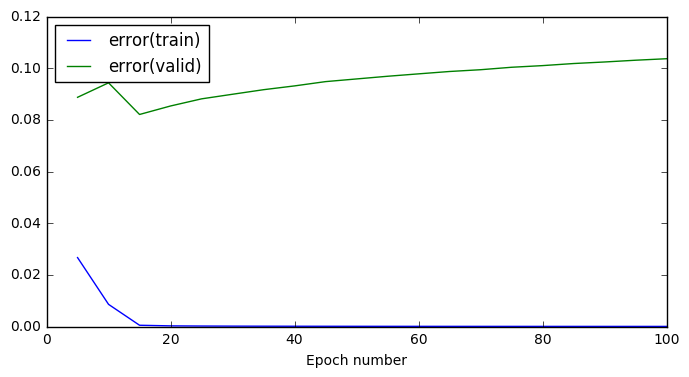

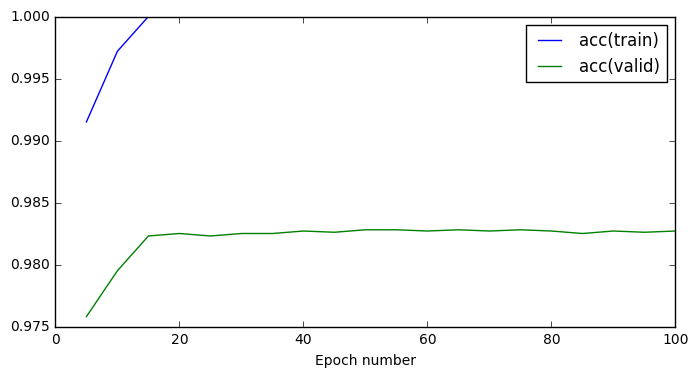

In [173]:
# Size of pools to take maximum over
pool_size = 2

input_dim, output_dim, hidden_dim = 784, 10, 100

# Use Glorot initialisation scheme for weights and zero biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Create three affine layer model interleaved with max-pooling layers
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim * pool_size, weights_init, biases_init), 
    MaxPoolingLayer(pool_size),
    AffineLayer(hidden_dim, hidden_dim * pool_size, weights_init, biases_init), 
    MaxPoolingLayer(pool_size),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError()

# Use a momentum learning rule - you could use an adaptive learning rule
# implemented for the coursework here instead
learning_rule = MomentumLearningRule(0.02, 0.9)

# Monitor classification accuracy during training
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

optimiser = Optimiser(
    model, error, learning_rule, train_data, valid_data, data_monitors)

num_epochs = 100
stats_interval = 5

stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')

The above settings for maxout seem to work very awesome except the fact that it in ~15%. But the validation accuracy remains at very good levels ~98.3%

Epoch 0:
  error(train)=2.50e+00, acc(train)=9.44e-02, error(valid)=2.50e+00, acc(valid)=9.46e-02, params_penalty=0.00e+00
Epoch 5: 3.69s to complete
  error(train)=2.03e-02, acc(train)=9.94e-01, error(valid)=8.63e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 10: 3.74s to complete
  error(train)=2.54e-03, acc(train)=1.00e+00, error(valid)=8.55e-02, acc(valid)=9.80e-01, params_penalty=0.00e+00
Epoch 15: 4.64s to complete
  error(train)=3.98e-04, acc(train)=1.00e+00, error(valid)=8.26e-02, acc(valid)=9.83e-01, params_penalty=0.00e+00
Epoch 20: 4.33s to complete
  error(train)=2.51e-04, acc(train)=1.00e+00, error(valid)=8.53e-02, acc(valid)=9.83e-01, params_penalty=0.00e+00
Epoch 25: 4.52s to complete
  error(train)=1.89e-04, acc(train)=1.00e+00, error(valid)=8.77e-02, acc(valid)=9.83e-01, params_penalty=0.00e+00
Epoch 30: 4.97s to complete
  error(train)=1.48e-04, acc(train)=1.00e+00, error(valid)=8.94e-02, acc(valid)=9.83e-01, params_penalty=0.00e+00
Epoch 35: 4.09s to complet

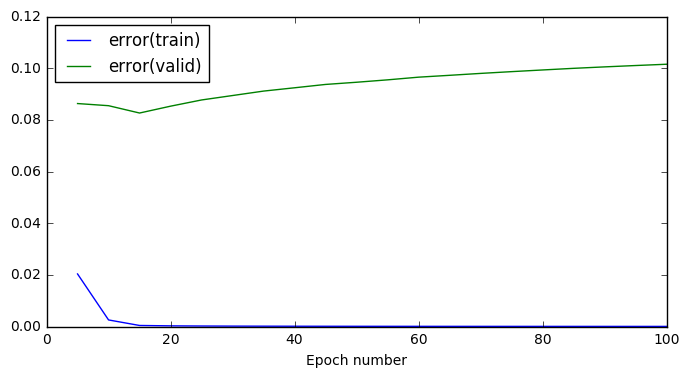

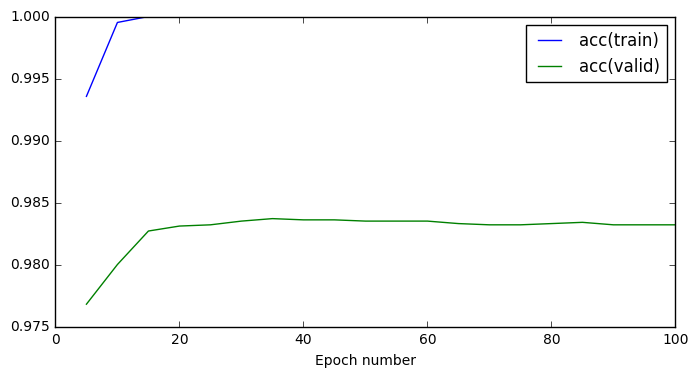

In [174]:
# Size of pools to take maximum over
pool_size = 3

input_dim, output_dim, hidden_dim = 784, 10, 100

# Use Glorot initialisation scheme for weights and zero biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Create three affine layer model interleaved with max-pooling layers
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim * pool_size, weights_init, biases_init), 
    MaxPoolingLayer(pool_size),
    AffineLayer(hidden_dim, hidden_dim * pool_size, weights_init, biases_init), 
    MaxPoolingLayer(pool_size),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError()

# Use a momentum learning rule - you could use an adaptive learning rule
# implemented for the coursework here instead
learning_rule = MomentumLearningRule(0.02, 0.9)

# Monitor classification accuracy during training
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

optimiser = Optimiser(
    model, error, learning_rule, train_data, valid_data, data_monitors)

num_epochs = 100
stats_interval = 5

stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')

Epoch 0:
  error(train)=2.43e+00, acc(train)=8.60e-02, error(valid)=2.43e+00, acc(valid)=8.71e-02, params_penalty=0.00e+00
Epoch 5: 6.36s to complete
  error(train)=2.14e-02, acc(train)=9.93e-01, error(valid)=8.13e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 10: 5.09s to complete
  error(train)=9.91e-04, acc(train)=1.00e+00, error(valid)=7.13e-02, acc(valid)=9.82e-01, params_penalty=0.00e+00
Epoch 15: 5.44s to complete
  error(train)=3.17e-04, acc(train)=1.00e+00, error(valid)=7.39e-02, acc(valid)=9.83e-01, params_penalty=0.00e+00
Epoch 20: 5.49s to complete
  error(train)=2.14e-04, acc(train)=1.00e+00, error(valid)=7.63e-02, acc(valid)=9.83e-01, params_penalty=0.00e+00
Epoch 25: 5.42s to complete
  error(train)=1.61e-04, acc(train)=1.00e+00, error(valid)=7.76e-02, acc(valid)=9.83e-01, params_penalty=0.00e+00
Epoch 30: 8.78s to complete
  error(train)=1.30e-04, acc(train)=1.00e+00, error(valid)=7.92e-02, acc(valid)=9.83e-01, params_penalty=0.00e+00
Epoch 35: 5.54s to complet

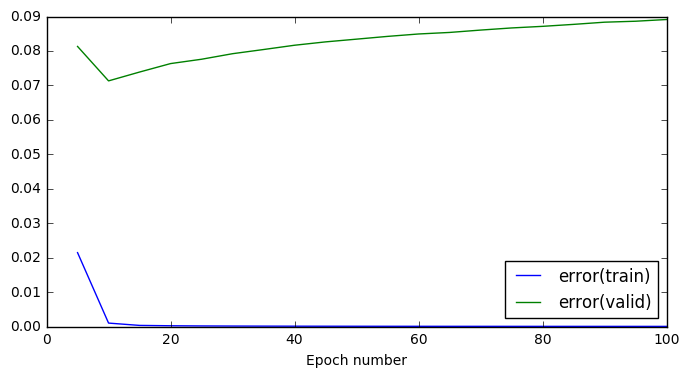

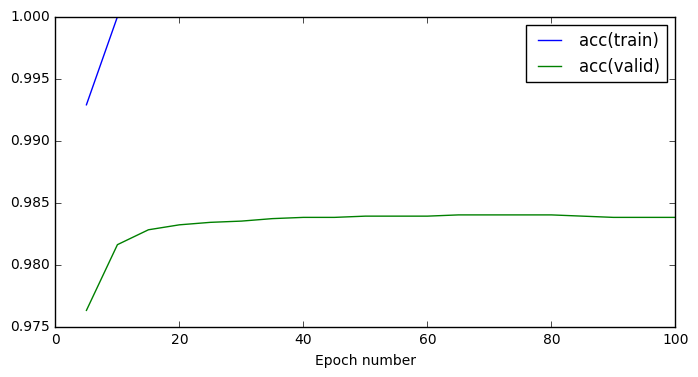

In [175]:
# Size of pools to take maximum over
pool_size = 4

input_dim, output_dim, hidden_dim = 784, 10, 100

# Use Glorot initialisation scheme for weights and zero biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Create three affine layer model interleaved with max-pooling layers
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim * pool_size, weights_init, biases_init), 
    MaxPoolingLayer(pool_size),
    AffineLayer(hidden_dim, hidden_dim * pool_size, weights_init, biases_init), 
    MaxPoolingLayer(pool_size),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError()

# Use a momentum learning rule - you could use an adaptive learning rule
# implemented for the coursework here instead
learning_rule = MomentumLearningRule(0.02, 0.9)

# Monitor classification accuracy during training
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

optimiser = Optimiser(
    model, error, learning_rule, train_data, valid_data, data_monitors)

num_epochs = 100
stats_interval = 5

stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')

The amazing thing with the maxout when pool size = 4 is that it is indeed slower because it involves more connections and again overfits within 10 epochs but the final (overfitted) validation error is lower than the two previous experience. Also the training accuracy is slightly but consistently higher at ~98.4%